In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting
import nilearn as nil
from glob import glob
import os
from nilearn.input_data import NiftiMasker
import subprocess
%matplotlib inline

# Phenotypical data

In [6]:
Pheno = pd.read_csv('Phenotypic_V1_0b_preprocessed1.csv')
Pheno.head()

,Unnamed: 0,Unnamed: 0.1,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,0,1,50002,1,50002,PITT,no_filename,1,1,16.77,...,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,fail,ERROR #24,1
1,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1


In [7]:
Demos = Pheno.ix[:,['SUB_ID','subject','SITE_ID','FILE_ID','DX_GROUP','AGE_AT_SCAN','SEX']]

In [8]:
Demos.groupby(['SEX','DX_GROUP']).count()['SUB_ID']

SEX  DX_GROUP
1    1           474
     2           474
2    1            65
     2            99
Name: SUB_ID, dtype: int64

# Download Reho data for each site

In [66]:
sites = Demos['SITE_ID'].unique()
sites

array(['PITT', 'OLIN', 'OHSU', 'SDSU', 'TRINITY', 'UM_1', 'UM_2', 'USM',
       'YALE', 'CMU', 'LEUVEN_1', 'LEUVEN_2', 'KKI', 'NYU', 'STANFORD',
       'UCLA_1', 'UCLA_2', 'MAX_MUN', 'CALTECH', 'SBL'], dtype=object)

In [67]:
for site in sites:
    print "Downloading data for site: " + site
    subprocess.call('python download_abide_preproc.py -d reho -p cpac -s filt_noglobal -o reho -t ' + site,shell=True)

# Resample MNI 152 to 3mm from 1mm

In [ ]:
mimg=nib.load('MNI152_T1_1mm_brain_mask.nii.gz')
mimg3mm = image.resample_img(mimg, target_affine=np.diag((3,3,3)))
mimg3mmd=mimg3mm.get_data()
affine = mimg3mm.affine
mimg3mmd_final=mimg3mmd[0:61,0:73,0:61]
mni=nib.Nifti1Image(mimg3mmd_final, affine)
mni.to_filename('MNI3mm.nii.gz')

## Create a mask based on a resampled MNI 152 to 3mm and mask all subjects

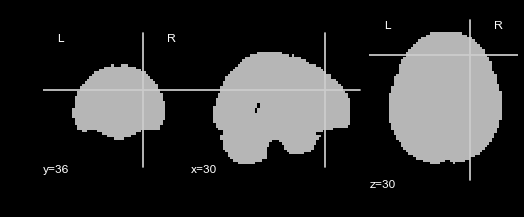

In [9]:
MNI = nib.load('./MNI3mm.nii.gz')
plotting.plot_anat(MNI)

# Build functions for testing and training

In [2]:
def trainModel(data, labels, classifier,modelDir,cv=True,k=5,masker=masker,sparse= False,saveData=True):
    '''Fill in docstring info'''

    from sklearn.metrics import accuracy_score
    
    if sparse:
        penalty = 'l1'
    else:
        penalty = 'l2'
                
    if classifier == 'svm':
        from sklearn.svm import LinearSVC
        algorithm = LinearSVC(penalty = penalty)
        if penalty == 'l1':
            algorithm.set_params(dual=False)
    elif classifier == 'logistic':
        from sklearn.linear_model import LogisticRegression
        algorithm = LogisticRegression(penalty = penalty)
        
    if cv:
        #CV and train model default 5-fold validation for hyperparameter tuning
        from sklearn.cross_validation import StratifiedKFold
        from sklearn.grid_search import GridSearchCV
        paramsToSearch = []        
        paramsToSearch.append({'C': [.001,.005,.01,.1,1,10]})
        clf = GridSearchCV(algorithm, paramsToSearch, cv=StratifiedKFold(labels, k))
    else:
        #Defaults and train model
        clf = algorithm
    
    clf.fit(data,labels)
    
    #Get training accuracy
    trainingPredictions = clf.predict(data)
    accuracy = accuracy_score(trainingPredictions, labels)
    print "Training accuracy: %f" % accuracy

    if cv:
        #Extract tuned model weights
        modelWeights = clf.best_estimator_.coef_[0]
        modelIntercept = clf.best_estimator_.intercept_
    else:
        #Extract deafult model weights
        modelWeights = clf.coef_[0]
        modelIntercept = clf.intercept_
    
    if saveData:
        from sklearn.externals import joblib
        #Write intercept + model weights to csv and weight image to nii
        fileName = os.path.join(modelDir,classifier)
        np.savetxt(fileName + '_Weights.csv',np.concatenate([modelIntercept,modelWeights]), delimiter=',', newline=os.linesep)
        np.savetxt(fileName + '_TrainAcc.csv',np.array([accuracy]), delimiter=',',newline=os.linesep)
        masker.inverse_transform(modelWeights).to_filename(fileName + '_Weights.nii.gz')
        joblib.dump(clf, fileName + '_Model.pkl')
        
    return clf
    

NameError: name 'masker' is not defined

In [57]:
def testModel(data, labels, classifier, modelDir, outputDir, saveData=True):
    '''Fill in docstring info'''
    
    from sklearn.externals import joblib
    from sklearn.metrics import accuracy_score
        
    modelPath = os.path.join(modelDir,classifier)
    outPath = os.path.join(outputDir,classifier)
    #If model doesn't exist use csv with coefs - TODO
    clf = joblib.load(modelPath + '_Model.pkl')
    predictions = clf.predict(data)
    
    #Compute accuracy on test data
    accuracy = accuracy_score(predictions,labels)
    print "Testing accuracy: %f" % accuracy
    
    if saveData:
        from sklearn.externals import joblib
        #Save accuracy
        np.savetxt(outPath + '_TestAcc.csv', np.array([accuracy]), delimiter=',',newline=os.linesep)
        #Save predictions
        np.savetxt(outPath + '_Predictions.csv',predictions, delimiter=',',newline=os.linesep)
    
    return accuracy   

# Test ground for sklearn functionality

In [10]:
subDir = '/Users/Esh/Documents/Dartmouth/Neurohackweek/kids/reho/Outputs/cpac/filt_noglobal/reho/'
subFiles = glob(os.path.join(subDir,'*.gz'))
masker = NiftiMasker(mask_img=MNI)
maskedSubs = masker.fit_transform(subFiles)

In [42]:
subNums = [int(f.split('_')[-2]) for f in subFiles]
labels = Pheno.ix[Pheno['SUB_ID'].isin(subNums),'DX_GROUP'].values

In [17]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [140]:
paramsToSearch = [{'kernel': ['linear'], 'C':[.001, .005, .01, .1, 1, 10]}]

clf = GridSearchCV(SVC(), paramsToSearch, cv=StratifiedKFold(labelsTrain, 5))
clf.fit(subsTrain, labelsTrain)
print "Best parameters set found on development set: "
print clf.best_params_
predictions = clf.predict(subsTest)
print accuracy_score(predictions,labelsTest)
print classification_report(labelsTest,predictions)


Best parameters set found on development set: 
{'kernel': 'linear', 'C': 0.005}
0.638418079096
             precision    recall  f1-score   support

          1       0.76      0.32      0.45        82
          2       0.61      0.92      0.73        95

avg / total       0.68      0.64      0.60       177



# Test new functions

In [68]:
subsTrain, subsTest, labelsTrain, labelsTest = train_test_split(maskedSubs,labels,train_size = 0.80, stratify=labels)

In [81]:
clf = trainModel(subsTrain,labelsTrain,'logistic','/Users/Esh/Documents/Dartmouth/Neurohackweek/kids/model',cv=True, sparse=True,saveData=True)

Training accuracy: 0.851485


In [76]:
testModel(subsTest,labelsTest,'svm','/Users/Esh/Documents/Dartmouth/Neurohackweek/kids/model','/Users/Esh/Documents/Dartmouth/Neurohackweek/kids/out')

Testing accuracy: 0.559322


0.55932203389830504

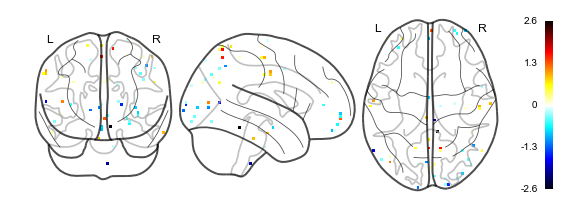

In [109]:
plotting.plot_glass_brain(masker.inverse_transform(clf.coef_),colorbar=True,plot_abs=False)

In [159]:
masker.inverse_transform(clf.best_estimator_.coef_).to_filename('weights.nii.gz')

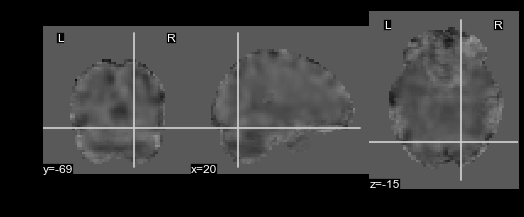

In [157]:
plotting.plot_anat(masker.inverse_transform(clf.best_estimator_.coef_))

In [3]:
weightMap = nib.load('weights.nii.gz')

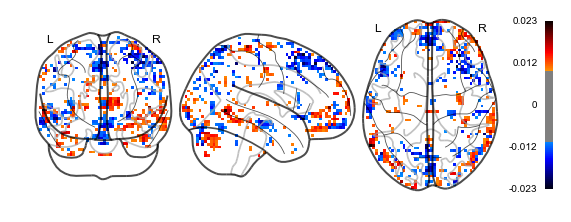

In [26]:
plotting.plot_glass_brain(weightMap,colorbar=True,plot_abs=False,threshold=.01)

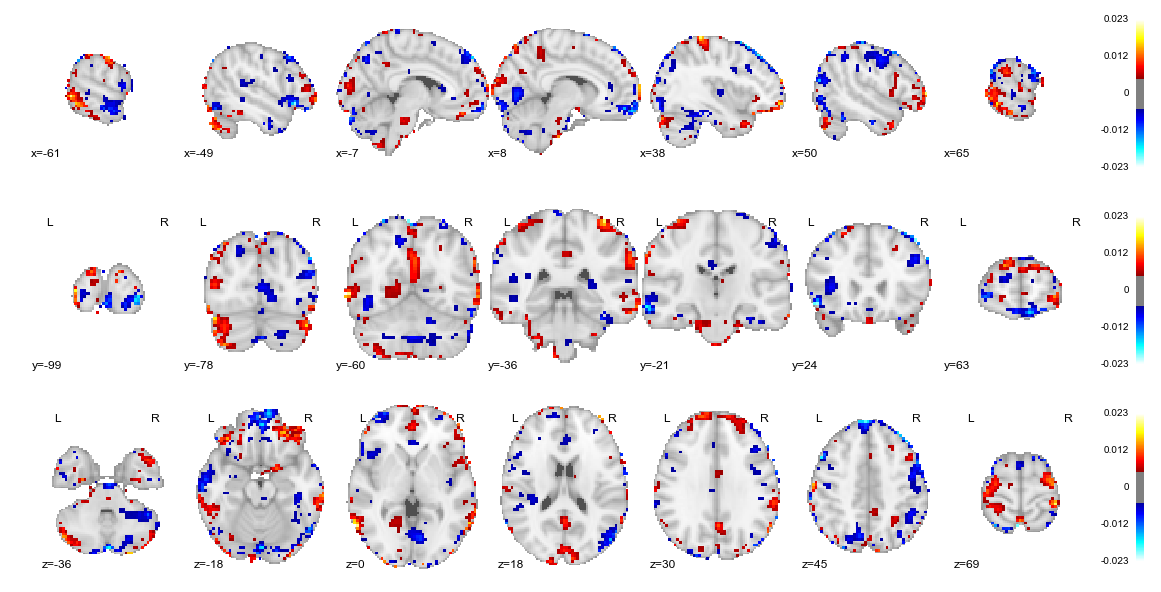

In [25]:
fig, ax = plt.subplots(3,1,figsize=(20,10))
plotting.plot_stat_map(weightMap,colorbar=True,draw_cross=False,threshold=.005,display_mode='x',axes=ax[0])
plotting.plot_stat_map(weightMap,colorbar=True,draw_cross=False,threshold=.005,display_mode='y',axes=ax[1])
plotting.plot_stat_map(weightMap,colorbar=True,draw_cross=False,threshold=.005,display_mode='z',axes=ax[2])

# Put it all together in a command line script

In [94]:
%%file runClassifier.py
#!/usr/bin/env python
import argparse
import os
import sys
import urllib
import pandas as pd
import subprocess
import glob
import nibabel as nib
import numpy as np
import sklearn
from nilearn.input_data import NiftiMasker
import nilearn
import csv

######################################
#Functions
######################################

def write_csv(listfile,filename):

	print('Writing to csv file:', filename)
	with open(filename, 'w') as f:
		f.writelines(listfile)

	return

#####################################

def get_features_mtx(pheno_file, mask_img,input_dir,output_path):
# get the feature matrix X, true values Y, mask image
	missing_data=['subjects\n']
	fnames=[]
	phenos = pd.read_csv(pheno_file,index_col=0)

	print('Parsing files')
	for ss in phenos.index:
		try:
			f = glob.glob(os.path.join(input_dir,'*%s*.nii.gz' % ss))[0]
			fnames.append(f)
		except:
			missing_data.append(str(ss)+'\n')


	trimmed_phenos = phenos[~phenos.index.isin(missing_data)]
	Y=trimmed_phenos['DX_GROUP'].values # labels or diagnosis group or Y for classifier

	mask=nib.load(mask_img)
	masker=NiftiMasker(mask_img=mask)

	print('Generating feature matrix nsubjects x voxels')
	# only brain functional voxels
	X=masker.fit_transform(fnames)
    
    print('Final feature matrix contains %d subjects and %d features', % (X.shape[0], X.shape[1]))
    
	write_csv(missing_data,os.path.join(output_path,'missing_data.csv'))
	return X,Y,masker

########################################
def trainModel(data, labels, classifier,modelDir,cv=True,k=5,masker=masker,sparse= False,saveData=True):
    
    ''' Train a linear classifier and save the model weights to a csv file, nii image and pickle the model.
    Args:
        data (ndarray): A data matrix organized as nsamples x nfeatures 
        labels (ndarray): A 1d labels array same length as nsamples  
        classifer (str): type of algorithm to use; currently 'svm' and 'logistic' are implemented
        modelDir (str): directory to store csv, nii and pickle model files
        cv (bool; optional): whether to tune hyper-paramters using cross-validation; default True
        k (int; optional): how many CV folds to use during hyper-parameter tuning; default 5
        masker (sklearn obj; optional): the NIFTI masker used to map X used to reshape data for nii file; default
            masker generated by get_features_mtx
        sparse (bool; optional): whether to fit a sparse model using L1 regularization; default False
        saveData (bool; optional): whether to actually save csv, nii, and pickle model or just return model object; 
            default True
    '''

    from sklearn.metrics import accuracy_score
    
    if sparse:
        penalty = 'l1'
    else:
        penalty = 'l2'
                
    if classifier == 'svm':
        from sklearn.svm import LinearSVC
        algorithm = LinearSVC(penalty = penalty)
        if penalty == 'l1':
            algorithm.set_params(dual=False)
    elif classifier == 'logistic':
        from sklearn.linear_model import LogisticRegression
        algorithm = LogisticRegression(penalty = penalty)
        
    if cv:
        #CV and train model default 5-fold validation for hyperparameter tuning
        from sklearn.cross_validation import StratifiedKFold
        from sklearn.grid_search import GridSearchCV
        paramsToSearch = []        
        paramsToSearch.append({'C': [.001,.005,.01,.1,1,10]})
        clf = GridSearchCV(algorithm, paramsToSearch, cv=StratifiedKFold(labels, k))
    else:
        #Defaults and train model
        clf = algorithm
    
    clf.fit(data,labels)
    
    #Get training accuracy
    trainingPredictions = clf.predict(data)
    accuracy = accuracy_score(trainingPredictions, labels)
    print "Training accuracy: %f" % accuracy

    if cv:
        #Extract tuned model weights
        modelWeights = clf.best_estimator_.coef_[0]
        modelIntercept = clf.best_estimator_.intercept_
    else:
        #Extract deafult model weights
        modelWeights = clf.coef_[0]
        modelIntercept = clf.intercept_
    
    if saveData:
        from sklearn.externals import joblib
        #Write intercept + model weights to csv and weight image to nii
        fileName = os.path.join(modelDir,classifier)
        np.savetxt(fileName + '_Weights.csv',np.concatenate([modelIntercept,modelWeights]), delimiter=',', newline=os.linesep)
        np.savetxt(fileName + '_TrainAcc.csv',np.array([accuracy]), delimiter=',',newline=os.linesep)
        masker.inverse_transform(modelWeights).to_filename(fileName + '_Weights.nii.gz')
        joblib.dump(clf, fileName + '_Model.pkl')
        
    return clf

######################################
def testModel(data, labels, classifier, modelDir, outputDir, saveData=True):
    
    ''' Test a linear classifier by loading a fitted model and returning predictions on given data.
    Args:
        data (ndarray): A data matrix organized as nsamples x nfeatures 
        labels (ndarray): A 1d labels array same length as nsamples  
        classifer (str): type of algorithm to use; currently 'svm' and 'logistic' are implemented
        modelDir (str): directory from which to load pickled model files
        outDir (str): directory to write csv file with testing accuracy and predictions
        saveData (bool; optional): whether to actually save csv or just return model object; 
            default True
    '''
    
    from sklearn.externals import joblib
    from sklearn.metrics import accuracy_score
        
    modelPath = os.path.join(modelDir,classifier)
    outPath = os.path.join(outputDir,classifier)
    #If model doesn't exist use csv with coefs - TODO
    clf = joblib.load(modelPath + '_Model.pkl')
    predictions = clf.predict(data)
    
    #Compute accuracy on test data
    accuracy = accuracy_score(predictions,labels)
    print "Testing accuracy: %f" % accuracy
    
    if saveData:
        from sklearn.externals import joblib
        #Save accuracy
        np.savetxt(outPath + '_TestAcc.csv', np.array([accuracy]), delimiter=',',newline=os.linesep)
        #Save predictions
        np.savetxt(outPath + '_Predictions.csv',predictions, delimiter=',',newline=os.linesep)
    
    return accuracy 


######################################
######################################

def run(command, env={}):
    process = Popen(command, stdout=PIPE, stderr=subprocess.STDOUT,
        shell=True, env=env)
    while True:
        line = process.stdout.readline()
        line = str(line, 'utf-8')[:-1]
        print(line)
        if line == '' and process.poll() != None:
            break


# Get arguments
parser = argparse.ArgumentParser(description='ABIDE Classifier Model')
parser.add_argument('--pheno_file', help='File containing the participant'
    'information for the analysis that will be run. This is a CSV with the'
    'participant id in the first column, the diagnosis in the'
    'second column.', required=True)
parser.add_argument('--input_dir', help='Directory with subject files', required=True)
parser.add_argument('--output_dir', help='Directory to contain output i.e. model weights and  model details',required=True)
parser.add_argument('--model_dir', help='Directory to store model objects if training and load model objects if testing',required=True)
parser.add_argument('--model', help='Type of classifier to use; one of: svm OR logistic', required=True)
parser.add_argument('--mask', help='Mask for non-zero brain tissue. Needs complete path',required=True)
parser.add_argument('--train', action='store_true')
parser.add_argument('--test', action='store_true')
parser.add_argument('--noCV',action='store_false',default=True, help='Indicate whether CV should be NOT used to tune hyperparameters and use sklearn defaults instead')
parser.add_argument('--k',,default=5, help='Indicate number of CV folds to use during hyper-parameter tuning; defaults to 5; ignored if --noCV is passed')
parser.add_argument('--sparse',action='store_true',default=False, help='Indicate whether a sparse model should be fit using L1 regularization; defaults to L2')
parser.add_argument('--nosave',action='store_false',default=True, help='Indicate whether models should be estimated but no files should be written; mostly for debugging')

# get the command line arguments
args = parser.parse_args()

# Check for correct and sufficient arguments
if args.train is None and args.test is None:
	parser.error('Enter flag for data: --train or --test')

# Check for mask
if not args.mask:
    parser.error('Need Mask Image')
else:
    mask_img=args.mask    

# Check for phenofile
if not args.pheno_file:
    parser.error('Need phenotype file with subject IDs and labels')
else:
    pheno_file = args.pheno_file

# Check for output directory
if not os.path.exists(args.output_dir):
    parser.error('Need output Directory!')
else:
    output_path=os.path.abspath(args.output_dir)
    
# Check for input directory
if not os.path.exists(args.input_dir):
    parser.error('Need input Directory!')
else:
    input_path=os.path.abspath(args.input_dir)
    
# Check for model directory
if not os.path.exists(args.model):
    parser.error('Need model Directory!')
else:
    model_path=os.path.abspath(args.model_dir)
                                
if not args.model:
    parser.error('Must specify one of the following models: svm or logistic')
else:
    classifier=args.model


#########################################
if args.train:
	print('Training new %s' % args.model)
    #Read input directory
    input_dir = args.input_dir

    # Get X or voxel wise features and Y for the classifier function in the sci-kit learn format
    #subj_ids = np.genfromtxt(args.pheno_file, usecols=0, delimiter=',', skip_header=1, dtype='str')
    X,Y,masker = get_features_mtx(pheno_file,mask_img,output_path)

    # Train the model based on subject and feature matrix
    clf = trainModel(X,Y,classifier,model_dir,cv=args.noCV,k=args.k,sparse=args.sparse,saveData=args.nosave)

elif args.test
    # Test a previously trained model
    testModel(X,Y,classifier,model_dir,out_dir,saveData=arg.nosave)
    

#########################################

Writing runClassifier.py
